<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#LDA-gensim" data-toc-modified-id="LDA-gensim-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LDA gensim</a></span></li><li><span><a href="#LDA-Mallet" data-toc-modified-id="LDA-Mallet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LDA Mallet</a></span></li><li><span><a href="#Sklearn-LDA" data-toc-modified-id="Sklearn-LDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sklearn LDA</a></span></li><li><span><a href="#Sklearn-Non-negative-Matrix-Factorization" data-toc-modified-id="Sklearn-Non-negative-Matrix-Factorization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Sklearn Non-negative Matrix Factorization</a></span></li></ul></div>

### Import libraries

In [335]:
import os
import numpy as np
import pandas as pd

from sklearn.decomposition import NMF
from normalization import normalize 
#from utils import build_feature_matrix, low_rank_svd 
import numpy as np 

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import gutenberg

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [306]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [348]:
def compute_coherence_values(corpus, texts, dictionary, k, a, eta):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=1,
                                           chunksize=3,
                                           passes=10,
                                           alpha=a,
                                           eta=eta)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [362]:
import itertools
import pandas as pd

def tune_hyperparams_gensim_LDA (corpus, texts, dictionary, k, a, eta):
    model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
    for parameters in itertools.product(k,a,eta):
        cv = compute_coherence_values(corpus=corpus, texts=texts, dictionary=dictionary, 
                                                  k=parameters[0], a=parameters[1], eta=parameters[2])
        model_results['Topics'].append(parameters[0])
        model_results['Alpha'].append(parameters[1])
        model_results['Beta'].append(parameters[2])
        model_results['Coherence'].append(cv)
        pd_results = pd.DataFrame(model_results)
        
    return pd_results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data preprocessing

In [122]:
books = []
books.append(gutenberg.raw('melville-moby_dick.txt'))
books.append(gutenberg.raw('carroll-alice.txt'))
books.append(gutenberg.raw('austen-emma.txt'))

In [123]:
print(books[0][:200])

[Moby Dick by Herman Melville 1851]


ETYMOLOGY.

(Supplied by a Late Consumptive Usher to a Grammar School)

The pale Usher--threadbare in coat, heart, body, and brain; I see him
now.  He was


In [275]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()
def normalize_corpus(corpus):
    corpus_lower = corpus.lower()
    #tokens = nltk.word_tokenize(corpus_lower)
    tokens = wtk.tokenize(corpus_lower)
    tags = nltk.pos_tag(tokens)
    tokens = [word.strip() for (word, tag) in tags if tag in ('NN', 'VB','VBD', 'JJ', 'ADV')]
#    tokens = [token.strip() for token in tokens ]
    tokens = [wnl.lemmatize(token) for token in tokens if token.isalpha() and not token.isnumeric()] 
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = list(filter(None, tokens))
            
    return tokens

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [276]:
books_norm = [normalize_corpus(book) for book in books]



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [277]:
print(books_norm[0][:100])

['dick', 'herman', 'melville', 'etymology', 'late', 'consumptive', 'usher', 'grammar', 'school', 'pale', 'usher', 'threadbare', 'coat', 'heart', 'body', 'brain', 'wa', 'old', 'queer', 'handkerchief', 'gay', 'world', 'loved', 'dust', 'old', 'reminded', 'mortality', 'hand', 'school', 'teach', 'name', 'whale', 'fish', 'tongue', 'ignorance', 'letter', 'signification', 'word', 'true', 'whale', 'sw', 'dan', 'hval', 'animal', 'roundness', 'dan', 'hvalt', 'webster', 'dictionary', 'whale', 'dut', 'ger', 'walw', 'ian', 'roll', 'wallow', 'richardson', 'dictionary', 'greek', 'cetus', 'latin', 'whoel', 'anglo', 'saxon', 'hvalt', 'danish', 'wal', 'dutch', 'hwal', 'swedish', 'whale', 'icelandic', 'whale', 'english', 'baleine', 'french', 'ballena', 'spanish', 'pekee', 'nuee', 'nuee', 'fegee', 'pekee', 'nuee', 'nuee', 'erromangoan', 'sub', 'sub', 'librarian', 'mere', 'burrower', 'grub', 'worm', 'poor', 'devil', 'sub', 'sub', 'long', 'street', 'earth']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [278]:
bigram = gensim.models.Phrases(books_norm, min_count=50, threshold=50)
#trigram = gensim.models.Phrases(bigram[book_norm], threshold=20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [279]:
bigram_model = gensim.models.phrases.Phraser(bigram)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [280]:
print(bigram_model[books_norm[0]][:100])

['dick', 'herman', 'melville', 'etymology', 'late', 'consumptive', 'usher', 'grammar', 'school', 'pale', 'usher', 'threadbare', 'coat', 'heart', 'body', 'brain', 'wa', 'old', 'queer', 'handkerchief', 'gay', 'world', 'loved', 'dust', 'old', 'reminded', 'mortality', 'hand', 'school', 'teach', 'name', 'whale', 'fish', 'tongue', 'ignorance', 'letter', 'signification', 'word', 'true', 'whale', 'sw', 'dan', 'hval', 'animal', 'roundness', 'dan', 'hvalt', 'webster', 'dictionary', 'whale', 'dut', 'ger', 'walw', 'ian', 'roll', 'wallow', 'richardson', 'dictionary', 'greek', 'cetus', 'latin', 'whoel', 'anglo', 'saxon', 'hvalt', 'danish', 'wal', 'dutch', 'hwal', 'swedish', 'whale', 'icelandic', 'whale', 'english', 'baleine', 'french', 'ballena', 'spanish', 'pekee', 'nuee', 'nuee', 'fegee', 'pekee', 'nuee', 'nuee', 'erromangoan', 'sub', 'sub', 'librarian', 'mere', 'burrower', 'grub', 'worm', 'poor', 'devil', 'sub', 'sub', 'long', 'street', 'earth']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [281]:
corpus_bigrams_norm = [bigram_model[book] for book in books_norm]
dictionary = gensim.corpora.Dictionary(bigram_model[corpus_bigrams_norm])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [282]:
print(list(dictionary.items())[:25])
print('Vocabulary Size:', len(dictionary))

[(0, 'aback'), (1, 'abaft'), (2, 'abandon'), (3, 'abandoned'), (4, 'abandonment'), (5, 'abased'), (6, 'abasement'), (7, 'abashed'), (8, 'abate'), (9, 'abated'), (10, 'abatement'), (11, 'abbreviate'), (12, 'abbreviation'), (13, 'abeam'), (14, 'abednego'), (15, 'abel'), (16, 'abhorred'), (17, 'abhorrence'), (18, 'abhorrent'), (19, 'abide'), (20, 'ability'), (21, 'abjectus'), (22, 'able'), (23, 'aboard'), (24, 'abode')]
Vocabulary Size: 12720


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [283]:
dictionary.filter_extremes(no_below=1, no_above=0.6)
print('Vocabulary Size:', len(dictionary))

Vocabulary Size: 9230


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [284]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(book) for book in corpus_bigrams_norm]
print(bow_corpus[1][:30])

[(7464, 1), (7465, 1), (7466, 1), (7467, 1), (7468, 310), (7469, 4), (7470, 1), (7471, 1), (7472, 1), (7473, 2), (7474, 1), (7475, 1), (7476, 1), (7477, 1), (7478, 1), (7479, 1), (7480, 2), (7481, 1), (7482, 1), (7483, 1), (7484, 1), (7485, 1), (7486, 1), (7487, 1), (7488, 1), (7489, 3), (7490, 2), (7491, 1), (7492, 7), (7493, 1)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [285]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:30]])

[('ada', 1), ('adjourn', 1), ('afore', 1), ('ahem', 1), ('alice', 310), ('ann', 4), ('annoy', 1), ('applause', 1), ('barley', 1), ('barrowful', 2), ('beauti', 1), ('beautify', 1), ('bee', 1), ('behind', 1), ('bough', 1), ('boxed', 1), ('brightened', 2), ('brush', 1), ('buttercup', 1), ('cackled', 1), ('camomile', 1), ('canary', 1), ('cardboard', 1), ('carrier', 1), ('carroll', 1), ('caucus', 3), ('cauldron', 2), ('chatte', 1), ('cheshire', 7), ('choking', 1)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA gensim

In [325]:
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary,
            chunksize=3, alpha='auto',
            eta='auto', random_state=0,
            iterations=500, num_topics=4,
            passes=30, eval_every=None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #1:
0.070*"emma" + 0.047*"harriet" + 0.041*"weston" + 0.035*"elton" + 0.034*"knightley" + 0.019*"jane" + 0.014*"frank_churchill" + 0.014*"hartfield" + 0.012*"woodhouse" + 0.012*"highbury" + 0.011*"miss_woodhouse" + 0.011*"miss_fairfax" + 0.010*"jane_fairfax" + 0.008*"smith" + 0.007*"churchill" + 0.006*"marry" + 0.006*"cole" + 0.005*"goddard" + 0.005*"donwell" + 0.005*"attachment"


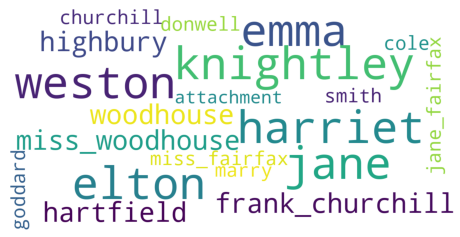

Topic #2:
0.000*"whale" + 0.000*"ship" + 0.000*"ahab" + 0.000*"boat" + 0.000*"queequeg" + 0.000*"stubb" + 0.000*"deck" + 0.000*"starbuck" + 0.000*"crew" + 0.000*"mast" + 0.000*"sperm_whale" + 0.000*"pequod" + 0.000*"thee" + 0.000*"oil" + 0.000*"nantucket" + 0.000*"sailor" + 0.000*"voyage" + 0.000*"harpooneer" + 0.000*"cabin" + 0.000*"ocean"


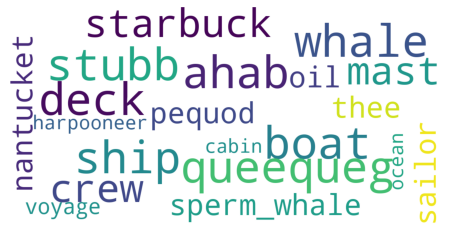

Topic #3:
0.094*"alice" + 0.017*"hatter" + 0.017*"gryphon" + 0.017*"mock_turtle" + 0.015*"rabbit" + 0.013*"duchess" + 0.012*"dormouse" + 0.004*"dinah" + 0.004*"dodo" + 0.003*"knave" + 0.002*"croquet" + 0.002*"twinkle" + 0.002*"mushroom" + 0.002*"oop" + 0.002*"lobster" + 0.002*"lory" + 0.002*"cheshire" + 0.002*"treacle" + 0.002*"remarked" + 0.002*"wow"


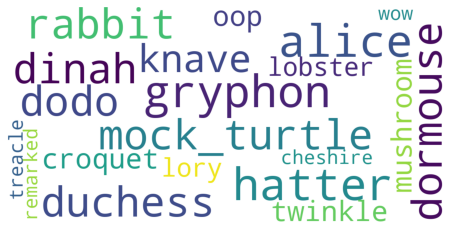

Topic #4:
0.036*"whale" + 0.018*"ship" + 0.013*"ahab" + 0.012*"boat" + 0.008*"stubb" + 0.007*"queequeg" + 0.007*"deck" + 0.006*"starbuck" + 0.006*"sperm_whale" + 0.006*"pequod" + 0.005*"crew" + 0.004*"mast" + 0.004*"thee" + 0.004*"voyage" + 0.003*"nantucket" + 0.003*"flask" + 0.003*"leviathan" + 0.003*"oil" + 0.003*"sail" + 0.003*"cabin"


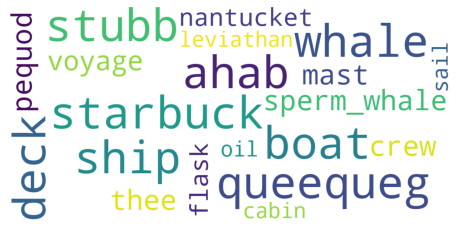

In [326]:
for topic_id, topic in lda_model.print_topics(num_topics=4, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    show_wordcloud(topic)
    plt.show()
#print()

In [327]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print(avg_coherence_score )

3.000044657137598e-12


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [328]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                      corpus=bow_corpus,
                                                      texts=corpus_bigrams_norm,
                                                      dictionary=dictionary,coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()
umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model,
                                                         corpus=bow_corpus,
                                                         texts=corpus_bigrams_norm,
                                                         dictionary=dictionary,
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()
perplexity = lda_model.log_perplexity(bow_corpus)
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Avg. Coherence Score (Cv): 0.6378732667155498
Avg. Coherence Score (UMass): 3.000044657137598e-12
Model Perplexity: -7.718843589010683


In [350]:
cv = compute_coherence_values(corpus=bow_corpus, texts =corpus_bigrams_norm, dictionary=dictionary, k=3, a=0.1, eta=0.1)
cv

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6973460900278314

In [363]:
pd_results = tune_hyperparams_gensim_LDA (corpus=bow_corpus, texts =corpus_bigrams_norm, dictionary=dictionary, k=[1,2,3,4], a=[0.1,0.3,1], eta=[0.1,0.5,1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [378]:
print(pd_results.sort_values(by=['Coherence'], ascending = False))

    Topics  Alpha  Beta  Coherence
18       3    0.1   0.1   0.697346
21       3    0.3   0.1   0.697346
24       3    1.0   0.1   0.697346
10       2    0.1   0.5   0.691770
17       2    1.0   1.0   0.691770
16       2    1.0   0.5   0.691770
15       2    1.0   0.1   0.691770
14       2    0.3   1.0   0.691770
9        2    0.1   0.1   0.691770
12       2    0.3   0.1   0.691770
11       2    0.1   1.0   0.691770
13       2    0.3   0.5   0.691770
30       4    0.3   0.1   0.691453
27       4    0.1   0.1   0.691453
33       4    1.0   0.1   0.675908
25       3    1.0   0.5   0.650694
28       4    0.1   0.5   0.643944
31       4    0.3   0.5   0.643944
34       4    1.0   0.5   0.643944
22       3    0.3   0.5   0.637106
23       3    0.3   1.0   0.637106
26       3    1.0   1.0   0.637106
19       3    0.1   0.5   0.637106
20       3    0.1   1.0   0.637106
29       4    0.1   1.0   0.589553
32       4    0.3   1.0   0.589553
35       4    1.0   1.0   0.589553
5        1    0.3   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA Mallet

In [365]:
#mallet_path = '/mallet-2.0.8/bin/mallet'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [366]:
#lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
#                                              corpus=bow_corpus,
#                                              num_topics=4,
#                                              id2word=dictionary,
#                                              iterations=500, workers=12)
#not available in gensim 4.0
#https://stackoverflow.com/questions/67095698/genism-module-attribute-error-for-wrappers

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Sklearn LDA

In [290]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [291]:
vectorizer = CountVectorizer(       
                            max_df=0.6, ngram_range=(1,2),
                            token_pattern='[a-zA-Z0-9]{3,}', 
                            max_features=5000,
                            tokenizer=lambda doc: doc,
                            preprocessor=lambda doc: doc
                            )
books_vectorized = vectorizer.fit_transform(books_norm)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [292]:
books_vectorized.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3, 5000)

In [319]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=4,               
                                      max_iter=10,              
                                      learning_method='online',   
                                      random_state=1,          
                                      batch_size=3,            
                                      evaluate_every = -1,       
                                      n_jobs = -1)               
lda_output = lda_model.fit_transform(books_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=3, learning_method='online',
                          n_components=4, n_jobs=-1, random_state=1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [320]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(books_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(books_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -293398.4989177317
Perplexity:  1286.1116364366753
{'batch_size': 3, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 4, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 1, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 0:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


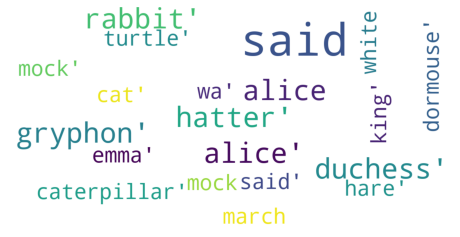


Topic 1:


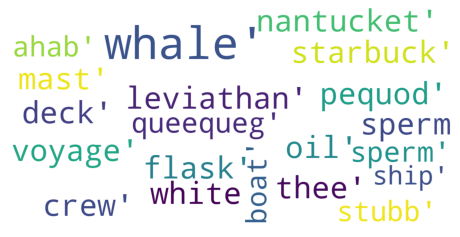


Topic 2:


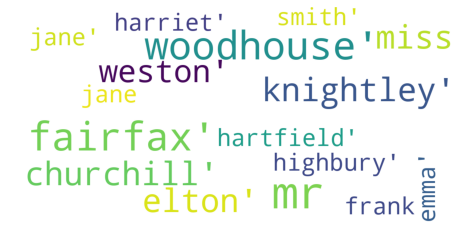


Topic 3:


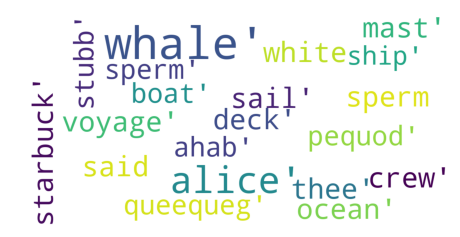

In [321]:
c_features = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda_model.components_):
    print ('\nTopic {}:'.format(topic_idx))
    top_features_ind = topic.argsort()[-20:]
    top_features = [c_features[i] for i in top_features_ind]
    weights = topic[top_features_ind]
#    for topic, weight in zip(top_features, weights):
#        print('{} - {:.5}'.format(topic, weight))
    show_wordcloud(top_features)
    plt.show()

### Sklearn Non-negative Matrix Factorization

In [296]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df=0.95, min_df=2,
                                   max_features=5000,
                                   stop_words='english',
                                   token_pattern='[a-zA-Z0-9]{3,}',
                                   tokenizer=lambda doc: doc,
                                   preprocessor=lambda doc: doc)
tfidf = tfidf_vectorizer.fit_transform(books_norm)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [297]:
tfidf.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3, 4195)

In [316]:
nmf = NMF(n_components=4, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, 
          alpha=.1, l1_ratio=.5).fit(tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 0:


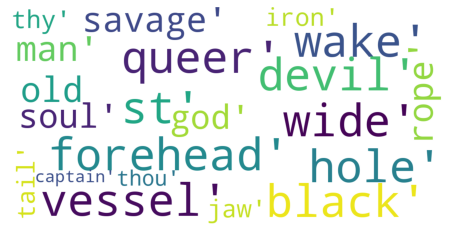


Topic 1:


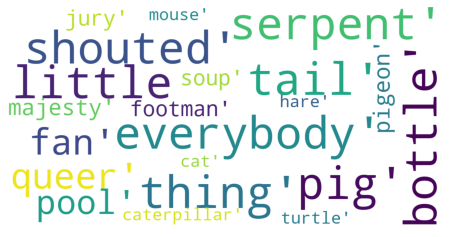


Topic 2:


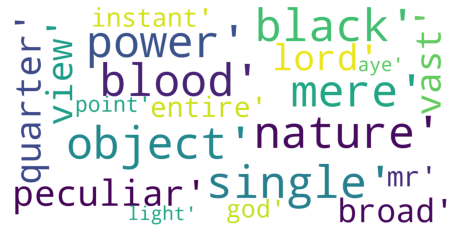


Topic 3:


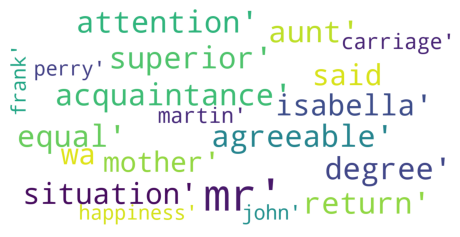

In [318]:
tfidf_features = tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
    print ('\nTopic {}:'.format(topic_idx))
    top_features_ind = topic.argsort()[-20:]
    top_features = [tfidf_features[i] for i in top_features_ind]
    weights = topic[top_features_ind]
#    for topic, weight in zip(top_features, weights):
#        print('{} - {:.5}'.format(topic, weight))
    show_wordcloud(top_features)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
